# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [1]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (24, 16)

## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts) - нужно самостоятельно разобрать и применить критерий качества для DBSCAN
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin


NOISE = -1


class Point(object):
    def __init__(self, cord):
        self.cord = cord.copy()
#         print(cord)
        self.processed = False
        self.cd = None
        self.rd = None
#         self.cd = np.inf
#         self.rd = np.inf
        self.clusterId = NOISE

    def dist(self, p):
        return np.linalg.norm(self.cord-p.cord)

    def setCoreDist(self, neighbors, MinPts):
        if self.cd is None:
            if len(neighbors) >= MinPts:
                self.cd = np.min([self.dist(n) for n in neighbors])


class OPTICS(BaseEstimator, ClusterMixin):
    '''
    Реализация алгоритма OPTICS
    '''

    def __init__(self, epsilon=1.0, MinPts=10, cluster_threshold=1.0, **kwargs):
        self.e = epsilon
        self.mp = MinPts
        self.th = cluster_threshold
        self.seeds = []
        self.ordered = []
        self.db = None
        self._path = []

    def _get_neighbors(self, point):
        return [n for n in self.db if (n is not point) and (n.dist(point) < self.e)]

    def _update_seeds(self, neighbors, core):
        cd = core.cd
        for n in neighbors:
            if not n.processed:
                new_rd = np.max([cd, core.dist(n)])
                if n.rd is None:
                    #                 if n.rd == np.inf:
                    n.rd = new_rd
                    self.seeds.append(n)
                else:
                    if new_rd < n.rd:
                        n.rd = new_rd
                        self.seeds.append(n)
        self.seeds = sorted(self.seeds, key=lambda n: n.rd)

    def _find_ordered(self):
        for p in self.db:
            if not p.processed:
                self._path.append(p)
                neighbors = self._get_neighbors(p)
                p.processed = True
                p.setCoreDist(neighbors, self.mp)
                self.ordered.append(p)
                if p.cd is not None:
                    #                 if p.cd == np.inf:
                    self._update_seeds(neighbors, p)
                    while self.seeds:
                        s = self.seeds.pop(0)
                        self._path.append(s)
                        neighbors = self._get_neighbors(s)
                        s.processed = True
                        s.setCoreDist(neighbors, self.mp)
                        self.ordered.append(s)
                        if s.cd is not None:
                            #                         if s.cd == np.inf:
                            self._update_seeds(neighbors, p)

    def fit(self, x):
        """
        Use data matrix x to compute model parameters
        """
        self.db = [Point(c) for c in x]
        self._find_ordered()
        return self

    def predict(self):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        clusters = []
        clusterId = NOISE
        for o in self.ordered:
            if o.rd is None:
                o.rd = float('infinity')
            if o.cd is None:
                o.cd = float('infinity')
            if o.rd > self.th:
                if o.cd <= self.th:
                    clusterId += 1
                    o.clusterId = clusterId
                    clusters.append(clusterId)
                else:
                    clusters.append(NOISE)
            else:
                o.clusterId = clusterId
                clusters.append(clusterId)
        wrong_cluster = [data[0] for data in np.stack(np.unique(
            clusters, return_counts=True), axis=-1) if data[1] < self.mp]

        clusterId = 0
        wrong_cluster.append(-1)
        cl_map = {}
        for o in self.ordered:
            if o.clusterId in wrong_cluster:
                o.clusterId = NOISE
                continue
            try:
                o.clusterId = cl_map[o.clusterId]
            except KeyError:
                cl_map[o.clusterId] = clusterId
                clusterId += 1
                o.clusterId = cl_map[o.clusterId]

        clusters = [p.clusterId for p in self.db]

        return np.array(clusters)

    def fit_predict(self, x):
        self.fit(x)
        return self.predict()

Создадим данные для отладки

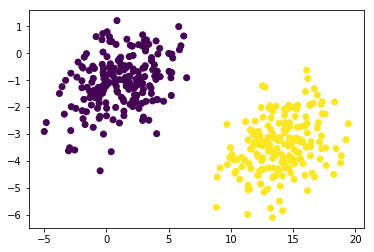

In [3]:
np.random.seed(0)
# C1 = np.array([[0., -0.8], [1.5, 0.8]])
C1 = np.array([[1., -0.7], [2., 0.7]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([8, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:, 0], X[:, 1], c=y)

Инициализируем и обучаем модель

In [4]:
optics = OPTICS()
optics.fit(X)

OPTICS(MinPts=None, cluster_threshold=None, epsilon=None)

Визуализируем обучение

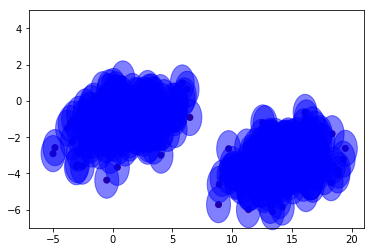

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# from IPython.display import HTML

plt.rcParams['animation.html'] = 'html5'


def plt_scatter(num, data, s):
    circle_fill = plt.Circle(
        data[num], optics.e, color='b', fill=True, clip_on=False, alpha=0.5)
    ax.add_artist(circle_fill)
    s.set_offsets(data[:num])
    circle.set_center(data[num])
    return s,


fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=np.zeros(X.shape[0]))
s = plt.scatter([], [])
plt.xlim(-7, 21)
plt.ylim(-7, 5)

circle = plt.Circle([0, 0], optics.e, color='r', fill=False, clip_on=False)
ax.add_artist(circle)

data = np.vstack([p.cord for p in optics._path])

scatter_ani = animation.FuncAnimation(fig, plt_scatter, X.shape[0], fargs=(data, s),
                                      interval=100, blit=False)
scatter_ani

Строим reachability distance

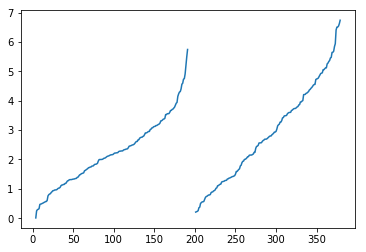

In [6]:
x = np.arange(X.shape[0])
plt.plot(x, [y.rd for y in optics.ordered])

{-1, 0, 1}

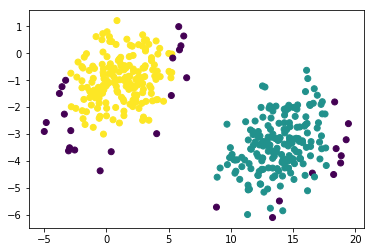

In [7]:
optics.th = 8
y_p = optics.predict()
# x = np.array([o.cord for o in optics.ordered])
plt.scatter(X[:, 0], X[:, 1], c=y_p)
set(y_p)

In [8]:
y_p

array([-1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

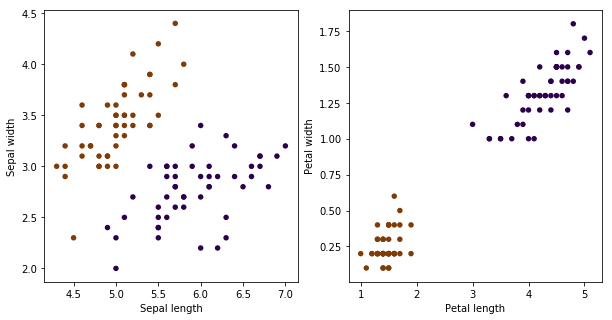

In [9]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_iris_scaler = scaler.fit_transform(x_iris)
# x_iris_scaler = x_iris

In [11]:
def detect_epsilon(x, minPTS, alpha=99):
    p = [Point(c) for c in x]
    dist = []
    for y in p:
        dist_n=[]
        for n in p:
            dist_n.append(y.dist(n))
        dist_n = sorted(dist_n)[:minPTS] 
        dist.extend(dist_n)
    dist = np.array(dist)
    return np.percentile(dist,alpha) # если очень много шума, то alpha, возможно, следует уменьшить


# dif_dist = dist[1:]-dist[:-1]
# dif2_dist = dif_dist[1:] - dif_dist[:-1]
e = detect_epsilon(x_iris_scaler,10)# данные слишком разряжены (низкая плотность)
# plt.plot(np.arange(len(dist)), dist, c='b')
# plt.plot(np.arange(len(dif2_dist)), dif2_dist, c='b')
# plt.plot([0, len(dist)], [model.e, model.e], c='r')
# plt.plot([0, len(dist)], [th_, th_], c='g')
print(e)

1.5444460373710378


In [12]:
model = OPTICS(epsilon=e)
model.fit(x_iris_scaler)

OPTICS(MinPts=None, cluster_threshold=None, epsilon=None)

4.166150386056125


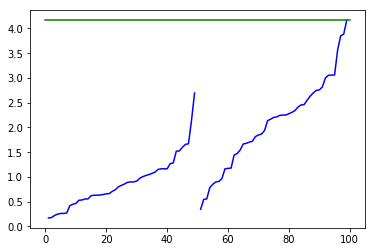

In [13]:
x = np.arange(x_iris_scaler.shape[0])
rds = [o.rd for o in model.ordered]
plt.plot(x, rds, c='b')
# plt.plot([0, x.size], [model.th, model.th], c='r')


def detect_th(model_fit):
    th = 0
    rds = [o.rd for o in model_fit.ordered]
#     isFirst =True
    for r in rds:
        if r == np.inf or r is None:
            continue
#             if isFirst:
#                 continue
#             else:
#                 break
#         isFirst = False
        if th < r:
            th = r
    return th


th = detect_th(model)

rds = [y for y in rds if y == np.inf]
plt.plot([0, x.size], [th, th], c='g')
print(th)

In [14]:
model.th = th
pred_iris = model.predict()
print("Adjusted Rand index for iris is: %.2f" %
      smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


In [15]:
pred_iris

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Text(0, 0.5, 'Petal width')

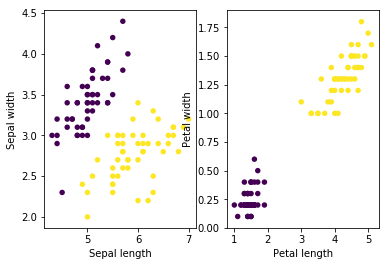

In [16]:
fig, ax = plt.subplots(1, 2)

ax[0].scatter(x_iris[:, 0], x_iris[:, 1], c=pred_iris, lw=0, s=30)
ax[0].set_xlabel('Sepal length')
ax[0].set_ylabel('Sepal width')

ax[1].scatter(x_iris[:, 2], x_iris[:, 3], c=pred_iris, lw=0, s=30)
ax[1].set_xlabel('Petal length')
ax[1].set_ylabel('Petal width')

Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

#### Замечание
Исходя из статьи по алгоритму OPTICS, параметры epsilon и minPts (в диапозоне для последнего 10-20, а дальше уже все не всегда хорошо) не сильно влияют на качество кластеризации, в некоторых реализациях от них отказываются. Порог cluster_threshold обычно подбирается в зависимости от конкретной задачи (т.е. на сколько важно ловить более маленькие кластеры в группе и т.п.). В связи с этим, не вижу смысла в реализации "критерия локтя", достаточно простых эвристик. На дальнейших данных будет показано, что в целом этого достаточно для разделения разных данных

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

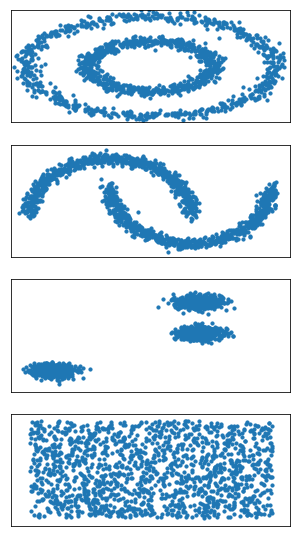

In [17]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

0 0.19378718159818523 3.7465520109535047
1 0.14697377929599542 2.5874913059289937
2 0.13321367102881337 0.7526721433749087
3 0.20467806056826277 3.286466691048279


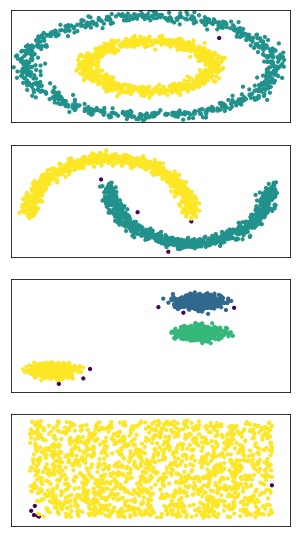

In [18]:
plt.figure(figsize=(2 + 3, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    e = detect_epsilon(X,10)
    m = OPTICS(epsilon=e, MinPts=10)
    m.fit(X)
    th = detect_th(m)
    m.th = th
    print(i_dataset, e, th)
    y = m.predict()

    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

## Дополнительное задание (не является обязательным)


Примените три любых алгоритма кластеризации из библиотеки sklearn на выбранном вами датасете (реальные данные, датасет с kaggle и пр.). Желательно выбрать легко интерпретируемые данные - например, данные о товарах или пользователях, где есть название, пол, возраст, а так же любые другие легко воспринимаемые признаки.

После применения алгоритма покажите в каждом кластере несколько представителей и проинтерпретируйте результат.

Считаем и очистим данные из датасета. Затем запишем в более простой формат.

In [19]:
# bst_dir = r'h3035'

In [20]:
# import DataAnalise

In [21]:
# import os
# def get_files_from_dir(directory):
#     """
#     Возвращает список файлов из директории dir
#     """
#     files = []
#     for file in os.listdir(directory):
#         if os.path.isfile(os.path.join(directory, file)):
#             files.append(file)
#     return files

In [22]:
# import pickle

# files = get_files_from_dir(bst_dir)
# files = sorted(files)
# all_bursts = {}
# days = {}
# print('reading bursts')
# for file in files:
#     bursts = []
#     with open(os.path.join(bst_dir, file), 'rb') as f:
#         nums = pickle.load(f)
#         for i in range(nums):
#             bursts.append(pickle.load(f))
#     num_bursts = len(bursts)
#     if num_bursts >= 50:
#         all_bursts[file] = bursts
#         days[file] = len(bursts)

In [23]:
# from DataAnalise.bursts.Statistic import Statistic

# # active_electrodes = []
# count_active_electrodes = ['active_electrodes']
# for days in all_bursts:
#     statistic = Statistic()
#     for burst in all_bursts[days]:
#         statistic.add_burst(burst)
#     active_electrodes.extend(statistic._active_electrodes)
#     count_active_electrodes.append(len(statistic._active_electrodes))
# active_electrodes = sorted(list(set(active_electrodes)))
# print('calculate vectors')
# all_vectors = []
# days_vectors = {}
# for i, days in enumerate(all_bursts):
#     vectors = []
#     for burst in all_bursts[days]:
#         if len(burst.electrodes) < count_active_electrodes[i + 1] * 0.25:
#             continue
#         vector = []
#         for electrode in active_electrodes:
#             if electrode in burst.electrodes:
#                 vector.append(burst.spikes[electrode][0, 0])
#             else:
#                 vector.append(-1)
#         vectors.append(vector)
#     if len(vectors) >= 10:
#         days_vectors[days[:-4]] = len(vectors)
#         all_vectors.extend(vectors)
#         # all_rnd_vectors.extend(rnd_vectors)
# last = 0
# y = []
# for i,days in enumerate(days_vectors):
#     y.extend(np.ones(days_vectors[days])*i)
#     days_vectors[days] += last
#     last = days_vectors[days]

# del all_bursts

# print('delete bad electrodes')

# all_vectors = np.array(all_vectors, dtype=np.float32).T
# all_vectors
# all_vectors.shape
# electrodes_activity = np.sum(all_vectors == -1, axis=1)
# new_active_electrodes = []
# new_all_vectors = []
# for i, electrode in enumerate(active_electrodes):
#     if electrodes_activity[i] > 0.50 * all_vectors.shape[1]:
#         continue
#     new_active_electrodes.append(electrode)
#     new_all_vectors.append(all_vectors[i, :])
# all_vectors = np.array(new_all_vectors).T
# active_electrodes = new_active_electrodes

# new_all_vectors = []
# for vector in all_vectors:
#     me = np.mean(vector[np.where(vector != -1)])
#     vector[np.where(vector == -1)] = me
#     new_all_vectors.append(vector)

# all_vectors = np.array(new_all_vectors)

In [24]:
# with open('data.pkl','wb') as f:
#     pickle.dump({'days':list(days_vectors.keys()), 'active_electrodes':active_electrodes, 'x':all_vectors, 'y':np.array(y)},f)

Считаем данные.
Данные представляют собой запись спонтанной пачечной биоэлектрической активности биологический нейронных сетей на мультиэлектродных матрицах. матрицы содержат 64 электрода. Представленна часовая активность 29 дней записи одной культуры. После выделения нужного вектора (фронта пачечной активации) остается 29 активных электродов.
Каждое измерение Х совершалось в день (у).


Исходная гипотеза, что если на нейроны не оказывается внешние воздействия(вроде внешней электрической стимуляции), то их активность изменяется не значительно. Если гипотеза верна должны получить 1 большой кластер.

Данные из готовящейся кандидатской диссертации

In [45]:
import pickle
with open('data.pkl','rb') as f:
    data=pickle.load(f)
days = data['days']
active_electrodes = data['active_electrodes']
X = data['x']
y = data['y']
X_t = StandardScaler().fit_transform(X)
del data

Попробуем визуализировать

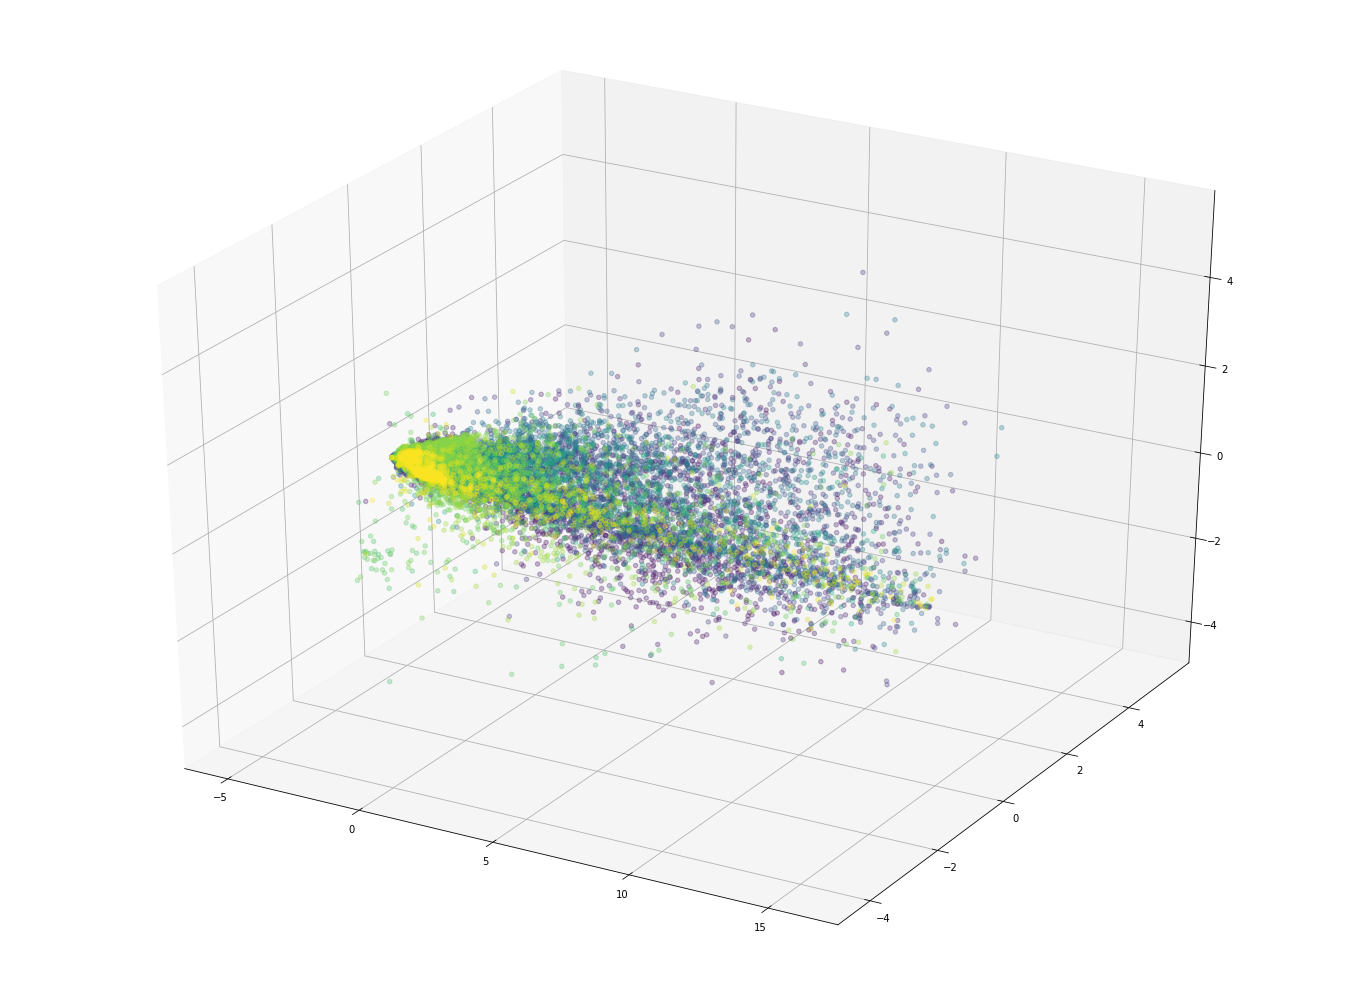

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
X3D = pca.fit_transform(X_t)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(24, 18))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X3D[:, 0], X3D[:, 1], X3D[:, 2],c=y,alpha=0.3 )

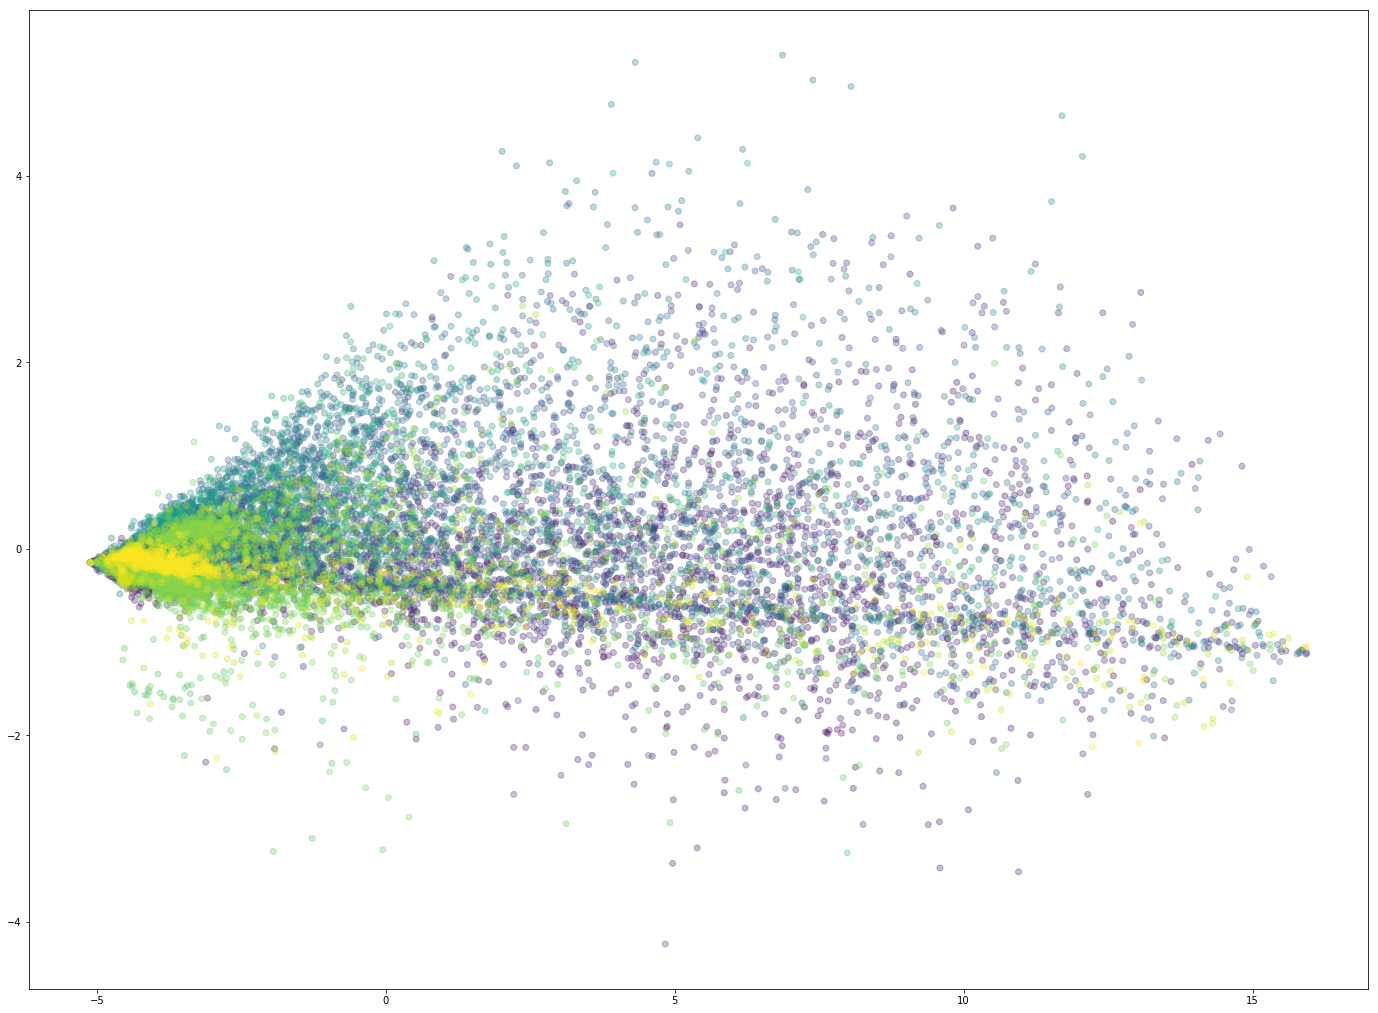

In [47]:
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X_t)

fig = plt.figure(figsize=(24, 18))
ax = fig.add_subplot(111)
ax.scatter(X2D[:, 0], X2D[:, 1],c=y,alpha=0.3 )

/home/necromant/.virtualenvs/datascience/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/necromant/.virtualenvs/datascience/lib/python3.6/site-packages/matplotlib/axes/_base.py:3461: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/home/necromant/.virtualenvs/datascience/lib/python3.6/site-packages/matplotlib/axes/_base.py:3122: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/home/necromant/.virtualenvs/datascience/lib/python3.6/site-packages/matplotlib/axes/_base.py:3128: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated i

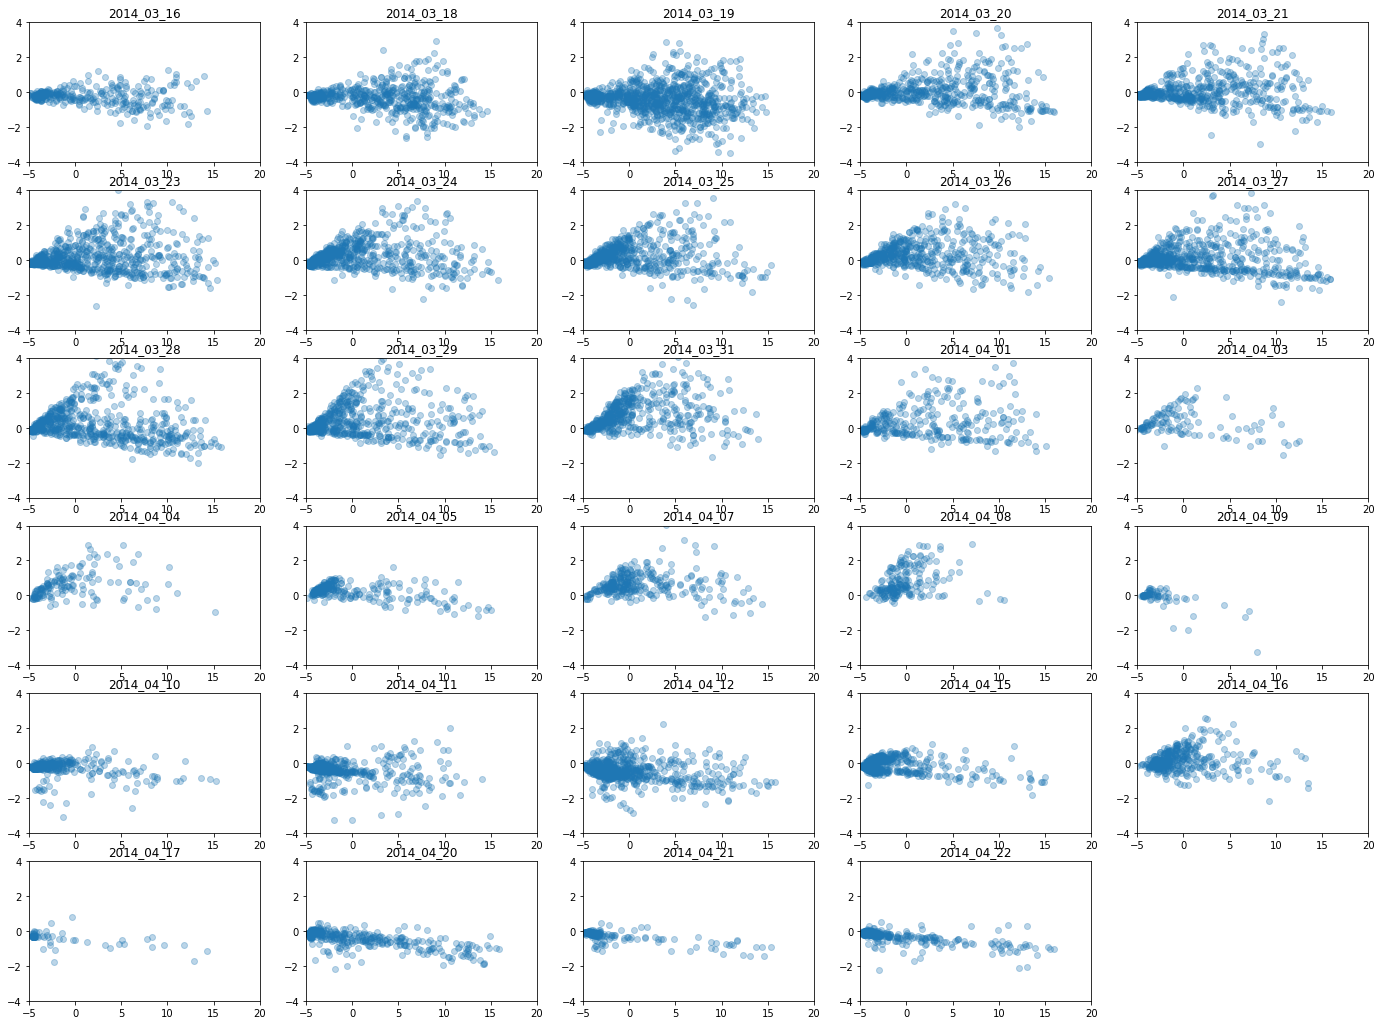

In [49]:
fig = plt.figure(figsize=(24, 18))
for i,day in enumerate(days):
    X_d = X2D[np.where(y==i)]
    ax = fig.add_subplot(6,5,i+1)
    ax.scatter(X_d[:, 0], X_d[:, 1],alpha=0.3 )
    ax.set_title(day)
    ax.set_ylim(ymin=-4, ymax=4)
    ax.set_xlim(xmin=-5, xmax=20)

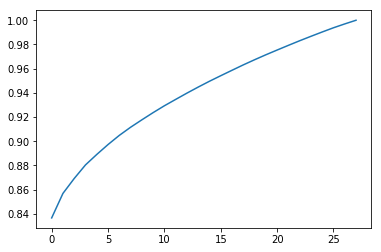

In [50]:
pca = PCA()
pca.fit(X_t)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

Снизить размерность без потерь не выйдет

In [60]:
old=True

In [61]:
#Вычисления занимают много времени. на моей машине парядка часа.
if not old: # если не будем загружать данные, то считаем
    e = detect_epsilon(X_t,10)
    m = OPTICS(epsilon=e, MinPts=10)
    m.fit(X_t)
    th = detect_th(m)
    m.th = th
    y_pred = m.predict()
    with open('model.pkl','wb') as f:
        pickle.dump({'model':m,'y_pred':y_pred},f)

In [62]:
if old:
    with open('model.pkl','rb') as f:
        data = pickle.load(f)
    y_pred = data['y_pred']
    m = data['model']

In [63]:
print(set(y_pred))

{0, -1}


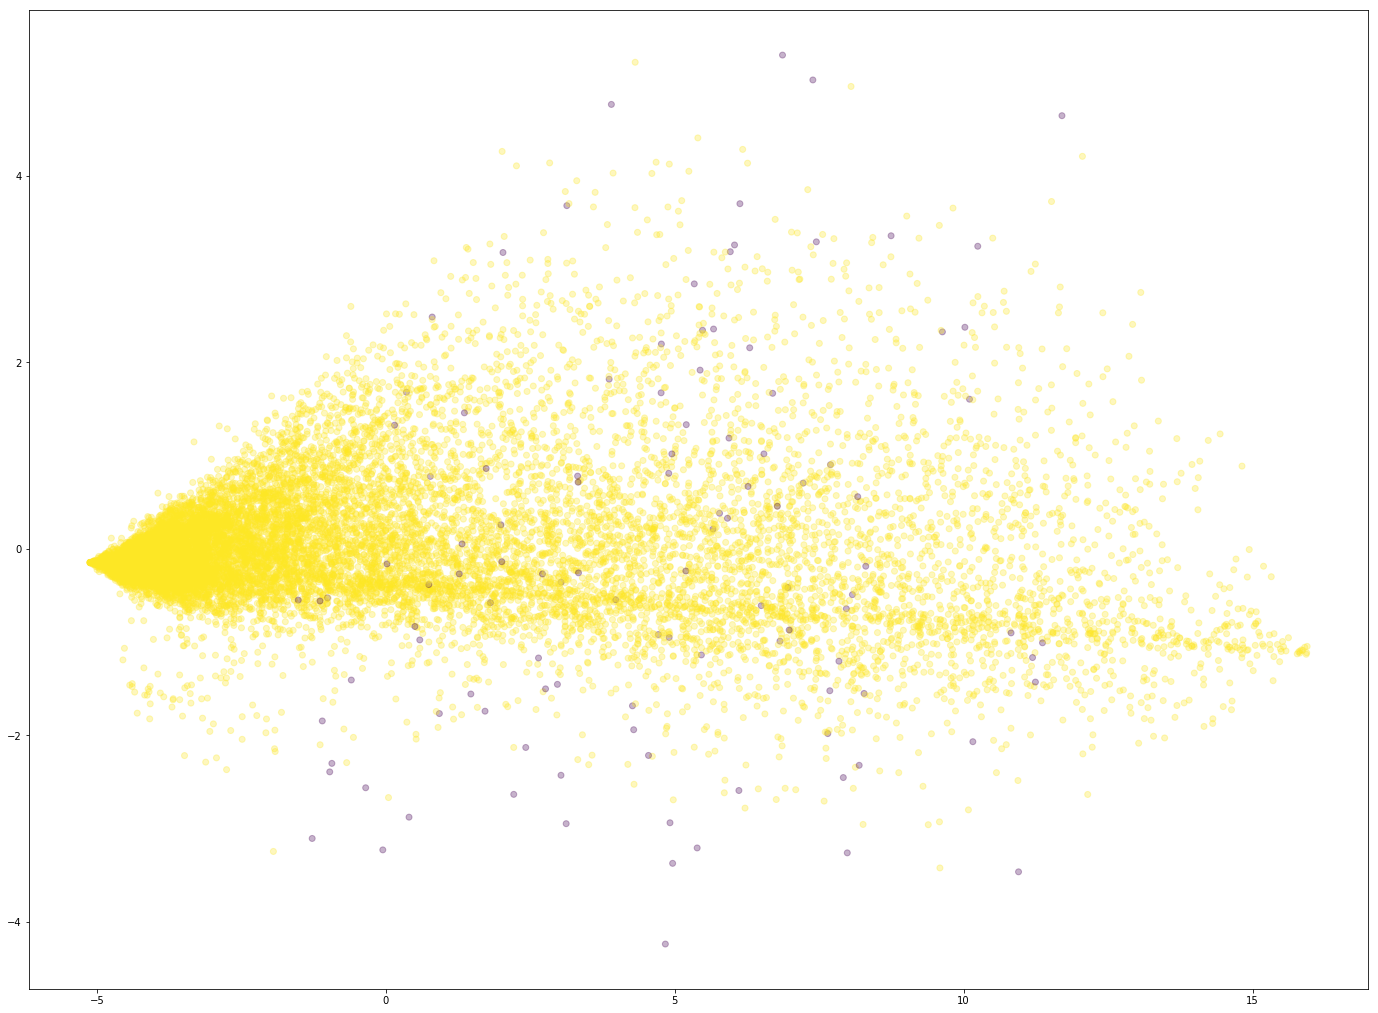

In [64]:
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X_t)

fig = plt.figure(figsize=(24, 18))
ax = fig.add_subplot(111)
ax.scatter(X2D[:, 0], X2D[:, 1],c=y_pred,alpha=0.3 )

Итого получился 1 кластер, что совпадает с ожиданием. Если бы активность менялась день ото дня, то получилось бы иное число кластеров.

Данные совпаадют с результатами иерархической кластеризации, которая используется в диссертации